In [ ]:
# Bring datasets

In [ ]:
import pandas as pd
#load osm data for KC
kc_osm_data = pd.read_csv('../../data/data_ohsome/new_kc_osm.csv')
#convert to geopandas dataframe
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data['geometry.coordinates'] = kc_osm_data['geometry.coordinates'].apply(lambda x: Point(eval(x)))
kc_osm_data = gpd.GeoDataFrame(kc_osm_data, geometry = 'geometry.coordinates', crs="EPSG:27700")
#Melt the dataframe
value_vars = ['properties.amenity', 'properties.healthcare', 'properties.office', 'properties.historic', 'properties.natural', 
              'properties.shop', 'properties.tourism', 'properties.leisure', 'properties.sport', 'properties.aeroway', 'properties.man_made', 
              'properties.waterway']
id_vars = [x for x in kc_osm_data.columns if x not in value_vars]
kc_osm_data2 = pd.melt(kc_osm_data, 
                       id_vars=id_vars, 
                       value_vars=value_vars, 
                       var_name= 'key',
                       value_name= 'value')
#remove none values from tags
kc_osm_data2 = kc_osm_data2.dropna(subset=['value']) 
#select certain columns
kc_osm_data2 = kc_osm_data2[["geometry.coordinates", "properties.@osmId", "key", "value"]]
#convert to geopandas dataframe
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data2['geometry.coordinates'] = kc_osm_data2['geometry.coordinates'].apply(Point)
#plot the data
kc_osm_data2 = gpd.GeoDataFrame(kc_osm_data2, geometry = 'geometry.coordinates', crs="EPSG:4326")
kc_osm_data2.plot()


In [ ]:
#Run spatial clustering using DBSCAN

In [4]:
from shapely.geometry import MultiPoint
#remove unnecessary values 
kc_osm_data2 = kc_osm_data2[~(kc_osm_data2.value.isin(["yes"]))]
kc_osm_data2['lon'] = kc_osm_data2['geometry.coordinates'].x
kc_osm_data2['lat'] = kc_osm_data2['geometry.coordinates'].y
kc_coords = kc_osm_data2[['lat', 'lon']].to_numpy()

C:\Users\smn18\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\smn18\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


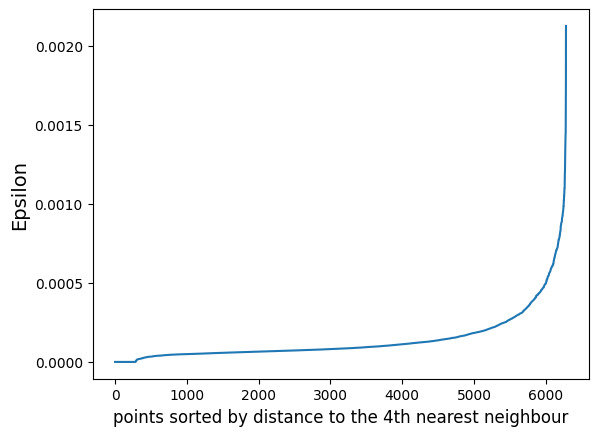

In [5]:
#finding the optimum epsilon
#Codes adopted from https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
#distance between each point and its k nearest neighbour
distances, indices = neighbors_fit.kneighbors(kc_coords)
#sort distances in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plot distances
plt.xlabel('points sorted by distance to the 4th nearest neighbour', fontsize=12)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

no. of clusters: 118
no of noise: 474


C:\Users\smn18\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


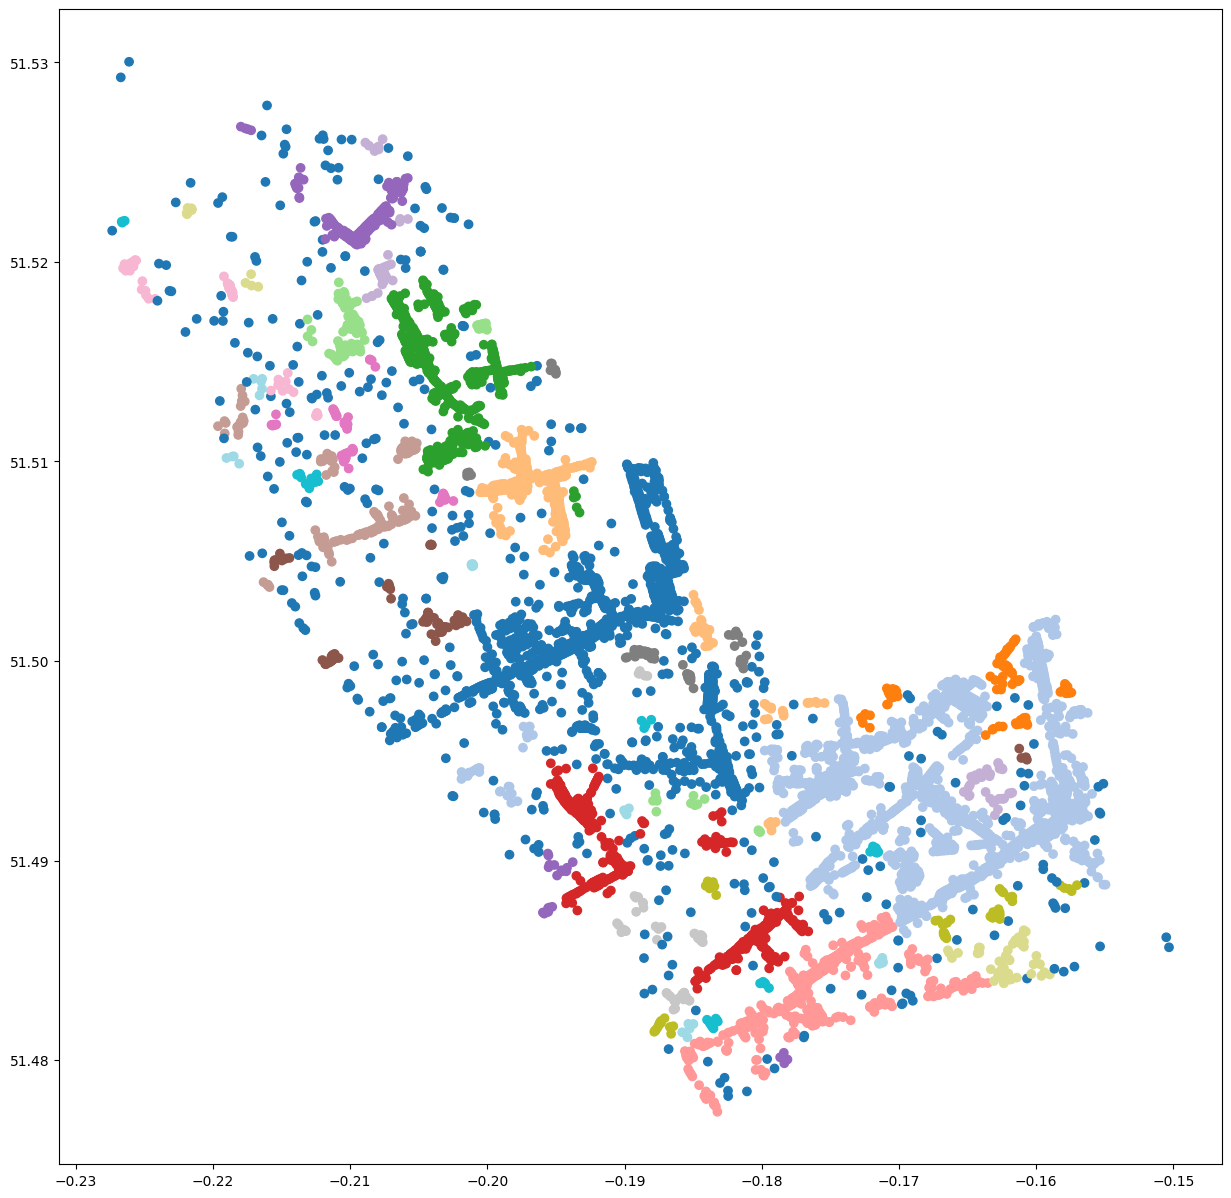

In [6]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0006, min_samples=4) #optimum epsilon 60m 
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
kc_osm_data2['cluster'] = dbscan_labels
import matplotlib.pyplot as plt
#plot dbscan
plt.figure(figsize=(15, 15))
plt.scatter(kc_osm_data2['lon'], 
            kc_osm_data2['lat'], 
            c=kc_osm_data2['cluster'],
            cmap='tab20')
#plt.savefig('../../docs/docs_ohsome/dbscan_osm_kc.png')

In [6]:
#Create polygons from DBBSCAN

In [7]:
#remove noise
remove = kc_osm_data2[kc_osm_data2['cluster'] == -1].index
kc_osm_data3 = kc_osm_data2.drop(remove)
#get tag list for each dbscan cluster as a list
osm_kc_dbscan = kc_osm_data3.groupby('cluster')['value'].apply(list)
data_dbscan = pd.DataFrame(osm_kc_dbscan)
tag_list_dbscan = data_dbscan.value.values.tolist()
data_dbscan

,value
cluster,
0,"[post_box, parking_entrance, dentist, dentist,..."
1,"[bicycle_rental, post_box, telephone, bicycle_..."
2,"[cafe, motorcycle_parking, car_sharing, post_b..."
3,"[post_box, pharmacy, post_box, bicycle_parking..."
4,"[restaurant, telephone, telephone, bicycle_par..."
...,...
112,"[tree, tree, tree, tree, hostel]"
113,"[tree, tree, tree, tree, tree, tree, tree, tree]"
114,"[car_wash, tree, tree, tree, tree]"


[<POLYGON ((-0.203 51.497, -0.201 51.502, -0.19 51.51, -0.188 51.51, -0.188 5...>, <POLYGON ((-0.205 51.497, -0.205 51.497, -0.205 51.497, -0.205 51.497, -0.20...>, <POLYGON ((-0.207 51.496, -0.207 51.496, -0.207 51.497, -0.206 51.497, -0.20...>, <POLYGON ((-0.194 51.496, -0.194 51.496, -0.193 51.497, -0.192 51.497, -0.19...>, <POLYGON ((-0.181 51.493, -0.187 51.493, -0.191 51.495, -0.191 51.495, -0.19...>, <POLYGON ((-0.198 51.493, -0.199 51.493, -0.198 51.494, -0.198 51.494, -0.19...>, <POLYGON ((-0.202 51.494, -0.202 51.494, -0.201 51.495, -0.201 51.494, -0.20...>, <POLYGON ((-0.197 51.496, -0.197 51.497, -0.197 51.497, -0.197 51.496, -0.19...>, <POLYGON ((-0.169 51.486, -0.176 51.489, -0.176 51.489, -0.174 51.492, -0.16...>, <POLYGON ((-0.178 51.492, -0.18 51.496, -0.174 51.498, -0.166 51.499, -0.165...>, <POLYGON ((-0.178 51.491, -0.178 51.491, -0.177 51.491, -0.177 51.491, -0.17...>, <POLYGON ((-0.163 51.499, -0.163 51.499, -0.163 51.499, -0.163 51.5, -0.161 ...>, <POLYGON ((-0.1

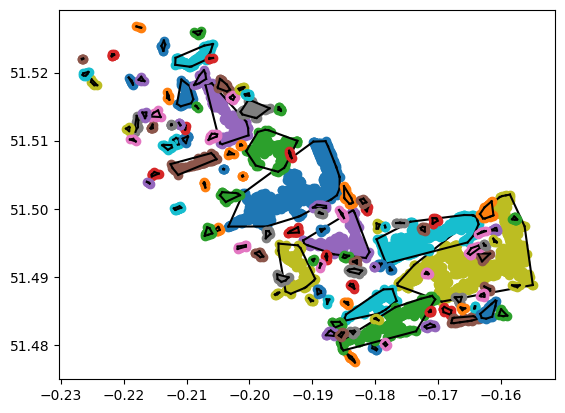

In [8]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = kc_osm_data3[["lon",
                   "lat",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,117):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["lon", "lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)
    
print(c_h)

In [9]:
#Bring BTM topic distribution run on R
##calling the saved kc_osm data from the folder
import pandas as pd
#load osm data for KC
kc_osm_topic_df = pd.read_csv('../../data/data_ohsome/topic_prob_df_oct.csv')

In [10]:
##add c_h polygon coordinates
kc_osm_topic_df['geometry'] = c_h
#set index as column
kc_osm_topic_df['cluster'] = kc_osm_topic_df.index

In [11]:
kc_osm_topic_df

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Topic,cluster,geometry
0,0,3.233426e-02,0.177106,3.419910e-02,1.223570e-01,2.262913e-02,1.346086e-01,0.275391,0.036991,1.094885e-01,5.489465e-02,V7,0,"POLYGON ((-0.203364 51.4973815, -0.2009744 51...."
1,1,2.479438e-05,0.642947,1.738393e-02,1.591714e-01,3.764994e-03,5.279975e-02,0.000968,0.019383,3.025297e-02,7.330465e-02,V2,1,"POLYGON ((-0.2052432 51.4966829, -0.2054768 51..."
2,2,6.327747e-08,0.470212,7.379187e-03,1.231440e-01,1.899725e-02,1.554944e-03,0.137046,0.225961,1.527835e-02,4.271479e-04,V2,2,"POLYGON ((-0.2071145 51.4960212, -0.2070454 51..."
3,3,1.069009e-03,0.458555,1.196840e-01,1.346363e-01,6.016822e-03,2.046233e-01,0.004831,0.020646,4.710976e-03,4.522772e-02,V2,3,"POLYGON ((-0.1938428 51.4964384, -0.1938025 51..."
4,4,1.515501e-02,0.322628,1.370860e-02,3.245304e-01,2.931657e-02,1.194096e-01,0.074419,0.051321,1.380801e-02,3.570461e-02,V4,4,"POLYGON ((-0.1814931 51.4927648, -0.1866066 51..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,7.460384e-06,0.000051,1.803278e-03,3.811940e-10,1.010276e-03,5.354290e-10,0.996788,0.000339,9.569425e-10,5.232617e-08,V7,112,"POLYGON ((-0.1898503 51.4923066, -0.1900369 51..."
113,113,1.346107e-12,0.000076,2.880313e-03,1.719731e-13,1.538475e-03,2.415553e-13,0.995001,0.000504,4.317183e-13,2.337914e-13,V7,113,"POLYGON ((-0.1714266 51.4848246, -0.1714626 51..."
114,114,2.502895e-08,0.070023,9.021601e-03,5.686426e-05,6.760383e-04,7.904449e-05,0.917651,0.002473,8.027187e-09,1.962989e-05,V7,114,"POLYGON ((-0.216609 51.5133124, -0.21704 51.51..."
115,115,1.518888e-08,0.459989,4.498190e-09,3.782443e-02,1.135432e-08,7.758345e-07,0.001496,0.000002,5.006883e-01,2.638000e-09,V9,115,"POLYGON ((-0.1854205 51.4811451, -0.1858025 51..."


In [12]:
#add topic labels
#Name the lda topics
def get_osm_topic_name(topic):
    if topic == 'V1':
        return 'Sports facilities, Gallery & Artwork'
    elif topic == 'V2':
        return 'Vehicle parking' 
    elif topic == 'V3':
        return 'Antiques and furniture shops'  
    elif topic == 'V4':
        return 'Restaurant, cafe and food shops' 
    elif topic == 'V5':
        return 'Diplomatic mission and commercial services'
    elif topic == 'V6':
        return 'Local shopping area'
    elif topic == 'V7':
        return 'Park & Green spaces' 
    elif topic == 'V8':
        return 'Healthcare facilities'
    elif topic == 'V9':
        return 'Urban furniture'
    else:
        return 'High street shops'
kc_osm_topic_df['BTM_topic_osm'] = kc_osm_topic_df['Topic'].apply(get_osm_topic_name)


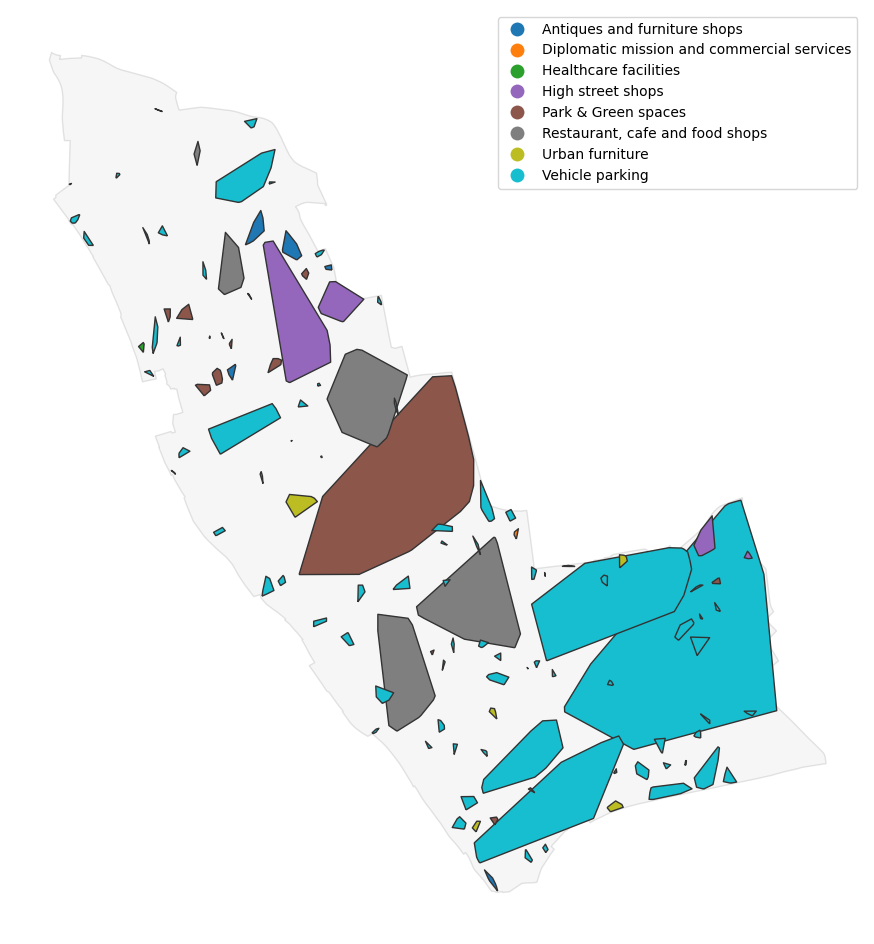

In [14]:
#Mapping without k-means
kc_osm_topic_gdf = gpd.GeoDataFrame(kc_osm_topic_df, geometry="geometry", crs='EPSG:4326')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 12))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
kc_osm_topic_gdf.plot(column='BTM_topic_osm', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='tab10', 
                      ax=ax, 
                      legend = True
                     )
ax.set_axis_off()

In [18]:
kc_osm_topic_gdf.to_csv('../../data/data_ohsome/osm_kc_btm_topics_oct.csv')